# Imports

In [2]:
import pandas as pd
import os
import json
import numpy as np
from sklearn.cluster import OPTICS, DBSCAN
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time

# Dataset exploring

In [10]:
# Load first 10 elemets of ground truth
gt_path = os.path.join("data", "gt.csv")
reader = pd.read_csv(gt_path, iterator=True)
reader.get_chunk(10)

,left_target_attribute,right_target_attribute,left_instance_attribute,right_instance_attribute,left_instance_value,right_instance_value,label
0,auto_focus_beam,auto_focus_beam,www.shopmania.in//1547//af illuminator,www.shopmania.in//1066//af illuminator,yes,yes,1
1,auto_focus_beam,auto_focus_beam,www.shopmania.in//859//af illuminator,www.ilgs.net//24//auto focus af assist beam,yes,yes,1
2,auto_focus_beam,auto_focus_beam,www.canon-europe.com//59//af assist beam,www.shopmania.in//858//af illuminator,yes,yes,1
3,auto_focus_beam,auto_focus_beam,www.shopmania.in//1458//af illuminator,www.cambuy.com.au//22//af assist beam,yes,yes,1
4,auto_focus_beam,auto_focus_beam,www.shopmania.in//1101//af illuminator,www.shopmania.in//858//af illuminator,yes,yes,1
5,auto_focus_beam,auto_focus_beam,www.shopmania.in//1547//af illuminator,www.cambuy.com.au//22//af assist beam,yes,yes,1
6,auto_focus_beam,auto_focus_beam,www.shopmania.in//1478//af illuminator,www.ilgs.net//24//auto focus af assist beam,yes,yes,1
7,auto_focus_beam,auto_focus_beam,www.shopmania.in//926//af illuminator,www.ilgs.net//134//auto focus af assist beam,yes,no,1
8,auto_focus_beam,auto_focus_beam,www.shopmania.in//1490//af illuminator,www.cambuy.com.au//103//af assist beam,yes,intermittent firing of built-in flash or emitt...,1
9,auto_focus_beam,auto_focus_beam,www.shopmania.in//1406//af illuminator,www.shopmania.in//1009//af illuminator,yes,yes,1


In [19]:
# Read ground truth elements chunk by chunk
reader = pd.read_csv(gt_path, chunksize=1000)
gt = pd.DataFrame()
for i, chunk in enumerate(reader):
    gt = pd.concat([gt, chunk])
    if i > 100:
        break
gt

,left_target_attribute,right_target_attribute,left_instance_attribute,right_instance_attribute,left_instance_value,right_instance_value,label
0,auto_focus_beam,auto_focus_beam,www.shopmania.in//1547//af illuminator,www.shopmania.in//1066//af illuminator,yes,yes,1
1,auto_focus_beam,auto_focus_beam,www.shopmania.in//859//af illuminator,www.ilgs.net//24//auto focus af assist beam,yes,yes,1
2,auto_focus_beam,auto_focus_beam,www.canon-europe.com//59//af assist beam,www.shopmania.in//858//af illuminator,yes,yes,1
3,auto_focus_beam,auto_focus_beam,www.shopmania.in//1458//af illuminator,www.cambuy.com.au//22//af assist beam,yes,yes,1
4,auto_focus_beam,auto_focus_beam,www.shopmania.in//1101//af illuminator,www.shopmania.in//858//af illuminator,yes,yes,1
...,...,...,...,...,...,...,...
101995,battery_type,battery_type,www.wexphotographic.com//170//battery model,www.wexphotographic.com//211//battery model,np-w126,nb-12l,1
101996,battery_type,battery_type,www.cambuy.com.au//82//battery,www.henrys.com//24//battery,one rechargeable li-ion en-el14a battery,en-el19,1
101997,battery_type,battery_type,www.eglobalcentral.co.uk//704//battery,www.wexphotographic.com//192//battery model,lithium-ion en-el15 rechargeable battery & cha...,en-el19,1
101998,battery_type,battery_type,www.henrys.com//172//battery,www.henrys.com//126//battery,en-el12,nb-10l,1


# Dataset loading

In [3]:
# I load the attributes in the specs DataFrame. Specs must be in folder ./data/specs
specs = pd.DataFrame()
specs_dir = os.path.join("data", "specs")
i = 0
for root_dir, _, files in os.walk(specs_dir):
    for file_name in files:
        if file_name.endswith(".json"):
            file_path = os.path.join(root_dir, file_name)
            
            with open(file_path, 'r') as json_file:
                json_dict = json.load(json_file)
                
            json_names = list(json_dict.keys())
            json_values = list(json_dict.values())
            json_np = np.vstack([json_names, json_values]).T
            json_df = pd.DataFrame(json_np, columns=["name", "value"])
            specs = pd.concat([specs, json_df])
            
            if i % 1000 == 0:
                print("Loaded", i, "files...")
            i += 1
specs

Loaded 0 rows...
Loaded 1000 rows...
Loaded 2000 rows...
Loaded 3000 rows...
Loaded 4000 rows...
Loaded 5000 rows...
Loaded 6000 rows...
Loaded 7000 rows...
Loaded 8000 rows...
Loaded 9000 rows...
Loaded 10000 rows...
Loaded 11000 rows...
Loaded 12000 rows...
Loaded 13000 rows...
Loaded 14000 rows...
Loaded 15000 rows...
Loaded 16000 rows...
Loaded 17000 rows...
Loaded 18000 rows...
Loaded 19000 rows...
Loaded 20000 rows...
Loaded 21000 rows...
Loaded 22000 rows...
Loaded 23000 rows...
Loaded 24000 rows...
Loaded 25000 rows...
Loaded 26000 rows...
Loaded 27000 rows...
Loaded 28000 rows...
Loaded 29000 rows...


,name,value
0,<page title>,Buy Canon EOS 5D Mark III Digital Camera (Body...
1,actual weight,33.50 oz
2,audio input type,Microphone
3,battery technology,Lithium ion
4,camera type,SLR camera
...,...,...
8,lens tele mm,224
9,lens wide mm,28
10,mpn,8195B010AA
11,optical zoom,5x


# Demo di clustering con OPTICS

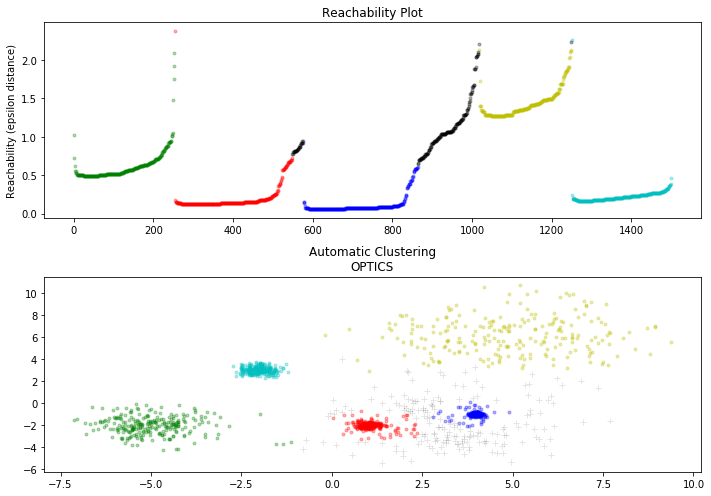

In [19]:
# Generate sample data

np.random.seed(0)
n_points_per_cluster = 250

C1 = [-5, -2] + .8 * np.random.randn(n_points_per_cluster, 2)
C2 = [4, -1] + .1 * np.random.randn(n_points_per_cluster, 2)
C3 = [1, -2] + .2 * np.random.randn(n_points_per_cluster, 2)
C4 = [-2, 3] + .3 * np.random.randn(n_points_per_cluster, 2)
C5 = [3, -2] + 1.6 * np.random.randn(n_points_per_cluster, 2)
C6 = [5, 6] + 2 * np.random.randn(n_points_per_cluster, 2)
X = np.vstack((C1, C2, C3, C4, C5, C6))

clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05)

# Run the fit
clust.fit(X)

space = np.arange(len(X))
# Produce un array ordinato che indica la "distanza" (raggiungibilità) di ogni punto dal suo cluster.
reachability = clust.reachability_[clust.ordering_]
# Produce un array ordinato che indica il cluster di appartenenza di ogni punto (mediante un ID).
labels = clust.labels_[clust.ordering_]
# I precedenti array sono ordinati in modo tale che i punti vicini nello spazio vettoriale siano adiacenti nell'array.

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 1)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, :])

# Reachability plot
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    # Prende gli indici di tutti i punti che appartengono alla classe klass.
    Xk = space[labels == klass]
    # Prende la raggiungibilità di tutti i punti che appartengono alla classe klass.
    Rk = reachability[labels == klass]
    # Plotta il grafico inidice/raggiungibilità
    ax1.plot(Xk, Rk, color, alpha=0.3)
# Plotta gli outliers (quelli con raggiungibilità troppo alta), che sono assegnati al cluster -1 (nessun cluster).
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    # Prende tutti i punti che appartengono alla classe klass.
    Xk = X[clust.labels_ == klass]
    # Plotta i punti della classe klass.
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
# Plotta i punti della classe -1.
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

plt.tight_layout()
plt.show()

In [14]:
clust.ordering_

array([  0,   3,   6, ..., 908, 873, 866])

In [15]:
clust.reachability_

array([       inf, 0.8851258 , 0.7643838 , ..., 1.9108775 , 1.27370383,
       1.34376381])

In [16]:
clust.reachability_[clust.ordering_]

array([       inf, 1.02299291, 0.72157342, ..., 0.37733713, 0.38277529,
       0.46184072])

In [20]:
clust.labels_

array([0, 0, 0, ..., 3, 3, 3])

In [22]:
np.unique(clust.labels_)

array([-1,  0,  1,  2,  3,  4])

In [21]:
clust.labels_[clust.ordering_]

array([0, 0, 0, ..., 4, 4, 4])

# Prova di clustering su un DataFrame dummy con vari algoritmi

In [4]:
# Genero dati a caso (della stessa dimensione di quelli veri)
dummy_specs = np.random.randn(528519, 200)

In [7]:
# Lancio OPTICS sui dati casuali.
start_time = time.time()
# Diminuendo max_eps l'algoritmo è più veloce.
clustery = OPTICS(max_eps=0.0000000001, n_jobs=-1)
clustery.fit(dummy_specs)
end_time = time.time()
print(end_time - start_time)
# Non termina mai anche con un max_eps bassissimo...

KeyboardInterrupt: 

In [5]:
# Lancio DBSCAN sui dati casuali.
clustery = DBSCAN(n_jobs=-1)
start_time = time.time()
clustery.fit(dummy_specs)
end_time = time.time()
print(end_time - start_time)

161.17482924461365


array([-1])